<a href="https://colab.research.google.com/github/Ojas-Mehta/RNNResearchSentimentAnalysis/blob/master/AllinOneSentimentAnalysisCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch
import torch.nn as nn
import pickle
import json
import pandas as pd
import os
import numpy as np
import csv
%matplotlib inline

In [0]:
init_list = []
for i in range(13):
  init_list.append(int(pow(3, i+18)))
iteration=0
for hidden_dim in [4]:
  for input_dim in [2]:
    for model_seed in [25, 28, 29, 30]:
      drive.mount('/content/drive')
      model_type = 'GRU'
      labelling_function = 'xor'
      sequence_length = 10
      vocab_size = 10
      embedding_seed = 27
      #model_seed = 2109
      #parameters
      # input_dim = 10
      output_dim = 2
      n_epochs = 150
      batch_size = 100
      lr = 0.001
      init_lr = lr
      # hidden_dim = 10
      patience_param = 4
      torch.manual_seed(embedding_seed)
      train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      train_X_list = train_data[0].tolist()
      train_y = train_data[1].tolist()
      val_X_list = val_data[0].tolist()
      val_y = val_data[1].tolist()
      test_X_list = test_data[0].tolist()
      test_y = test_data[1].tolist()
      def stringToList(string):
          string = string[1:len(string)-1]
          if len(string) != 0: 
              tempList = string.split(", ")
              newList = list(map(lambda x: int(x), tempList))
          else:
              newList = []
          return(newList)
      train_X_list = [stringToList(x) for x in train_X_list]
      train_X = torch.tensor(train_X_list, dtype=torch.long)
      val_X_list = [stringToList(x) for x in val_X_list]
      val_X = torch.tensor(val_X_list, dtype=torch.long)
      test_X_list = [stringToList(x) for x in test_X_list]
      test_X = torch.tensor(test_X_list, dtype=torch.long)
      #Get embeddings
      embeddings = nn.Embedding(vocab_size, input_dim)
      train_input = embeddings(train_X)
      train_output = torch.tensor(train_y, dtype=torch.long)
      val_input = embeddings(val_X)
      val_output = torch.tensor(val_y, dtype=torch.long)
      test_input = embeddings(test_X)


      torch.manual_seed(model_seed)
      #Code used for TRAINING
      def evaluate(tempmodel, dataX, dataY, criterion):
          epoch_loss = 0
          epoch_acc = 0
          correct_pred = 0
          tempmodel.eval()
          with torch.no_grad():
              for i in range(0, dataX.shape[0], batch_size):
                  batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
                  batchX = batchX.to(device)
                  batchy = batchy.to(device)
                  output, hidden = tempmodel(batchX)          
                  loss = criterion(hidden, batchy)

                  epoch_loss += loss.item()*batch_size
                  _, predicted_labels = torch.max(hidden, 1)
                  correct_pred += (predicted_labels==batchy).sum().item()
              accuracy = correct_pred/ len(dataX)*100
              epoch_loss /= len(dataX)   
          return epoch_loss, accuracy

      if torch.cuda.is_available():
          device = torch.device("cuda")
          print("GPU is available")
      else:
          device = torch.device("cpu")
          print("GPU not available, CPU used")
        
      class Model(nn.Module):
          def __init__(self, input_size, output_size, hidden_dim, n_layers):
              super(Model, self).__init__()

              self.hidden_dim = hidden_dim
              self.n_layers = n_layers

              #Defining the layers
              if model_type== 'RNN':
                self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
              elif model_type== 'GRU':
                self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
              self.fc = nn.Linear(hidden_dim, output_size)
          
          def forward(self, x):
              
              hidden = self.init_hidden(batch_size)

              out, hidden = self.rnn(x, hidden)
              hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
              hidden = self.fc(hidden)
              return out, hidden
          
          def init_hidden(self, batch_size):
              hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
              hidden = hidden.to(device)
              return hidden
            
      # Instantiate the model with hyperparameters
      model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
      model.to(device)

      # Define Loss, Optimizer
      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)
      model = model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
      k = 0
      training_loss = []
      validation_loss = []

      print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
      curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
      print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
      training_loss.append([0, curTrainLoss, curTrainAccuracy])
      curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
      print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
      validation_loss.append([0, curValLoss, curValAccuracy])
      oldAcc = curValAccuracy

      for epoch in range(1, n_epochs + 1):
          model.train()
          for i in range(0, train_input.shape[0], batch_size):
              optimizer.zero_grad()
              batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
              batch_X = batch_X.to(device)
              batch_y = batch_y.to(device)
              output, hidden = model(batch_X)
              loss = criterion(hidden, batch_y)
              loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
              optimizer.step() # Updates the weights accordingly
          
          print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
          curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
          print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
          training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
          curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
          print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
          validation_loss.append([epoch, curValLoss, curValAccuracy])
          final_epoch = epoch
          if(oldAcc>=curValAccuracy):
            if oldAcc>curValAccuracy:
              lr/=2
            k+=1
          else:
            k=0
          if(k>=patience_param or lr<1e-6):
            break
          oldAcc = curValAccuracy
      print('Training Done.')

      torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
      if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
        with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
          try:
            collection = json.loads(readjson.read())
          except ValueError:
            collection = []
      else:
        collection=[]
      with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
        collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
        collection.append(collection_entry)
        json.dump(collection, f)
        print(iteration)
        iteration+=1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available


In [0]:
iteration=0
for hidden_dim in [2, 4, 8, 16]:
  for input_dim in [2, 5, 10, 15]:
    for model_seed in [27, 108, 2754]:
      drive.mount('/content/drive')
      model_type = 'GRU'
      labelling_function = 'first'
      sequence_length = 10
      vocab_size = 10
      embedding_seed = 27
      #model_seed = 2109
      #parameters
      # input_dim = 10
      output_dim = 2
      n_epochs = 150
      batch_size = 100
      lr = 0.001
      init_lr = lr
      # hidden_dim = 10
      patience_param = 4
      torch.manual_seed(embedding_seed)
      train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      train_X_list = train_data[0].tolist()
      train_y = train_data[1].tolist()
      val_X_list = val_data[0].tolist()
      val_y = val_data[1].tolist()
      test_X_list = test_data[0].tolist()
      test_y = test_data[1].tolist()
      def stringToList(string):
          string = string[1:len(string)-1]
          if len(string) != 0: 
              tempList = string.split(", ")
              newList = list(map(lambda x: int(x), tempList))
          else:
              newList = []
          return(newList)
      train_X_list = [stringToList(x) for x in train_X_list]
      train_X = torch.tensor(train_X_list, dtype=torch.long)
      val_X_list = [stringToList(x) for x in val_X_list]
      val_X = torch.tensor(val_X_list, dtype=torch.long)
      test_X_list = [stringToList(x) for x in test_X_list]
      test_X = torch.tensor(test_X_list, dtype=torch.long)
      #Get embeddings
      embeddings = nn.Embedding(vocab_size, input_dim)
      train_input = embeddings(train_X)
      train_output = torch.tensor(train_y, dtype=torch.long)
      val_input = embeddings(val_X)
      val_output = torch.tensor(val_y, dtype=torch.long)
      test_input = embeddings(test_X)


      torch.manual_seed(model_seed)
      #Code used for TRAINING
      def evaluate(tempmodel, dataX, dataY, criterion):
          epoch_loss = 0
          epoch_acc = 0
          correct_pred = 0
          tempmodel.eval()
          with torch.no_grad():
              for i in range(0, dataX.shape[0], batch_size):
                  batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
                  batchX = batchX.to(device)
                  batchy = batchy.to(device)
                  output, hidden = tempmodel(batchX)          
                  loss = criterion(hidden, batchy)

                  epoch_loss += loss.item()*batch_size
                  _, predicted_labels = torch.max(hidden, 1)
                  correct_pred += (predicted_labels==batchy).sum().item()
              accuracy = correct_pred/ len(dataX)*100
              epoch_loss /= len(dataX)   
          return epoch_loss, accuracy

      if torch.cuda.is_available():
          device = torch.device("cuda")
          print("GPU is available")
      else:
          device = torch.device("cpu")
          print("GPU not available, CPU used")
        
      class Model(nn.Module):
          def __init__(self, input_size, output_size, hidden_dim, n_layers):
              super(Model, self).__init__()

              self.hidden_dim = hidden_dim
              self.n_layers = n_layers

              #Defining the layers
              if model_type== 'RNN':
                self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
              elif model_type== 'GRU':
                self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
              self.fc = nn.Linear(hidden_dim, output_size)
          
          def forward(self, x):
              
              hidden = self.init_hidden(batch_size)

              out, hidden = self.rnn(x, hidden)
              hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
              hidden = self.fc(hidden)
              return out, hidden
          
          def init_hidden(self, batch_size):
              hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
              hidden = hidden.to(device)
              return hidden
            
      # Instantiate the model with hyperparameters
      model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
      model.to(device)

      # Define Loss, Optimizer
      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)
      model = model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
      k = 0
      training_loss = []
      validation_loss = []

      print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
      curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
      print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
      training_loss.append([0, curTrainLoss, curTrainAccuracy])
      curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
      print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
      validation_loss.append([0, curValLoss, curValAccuracy])
      oldAcc = curValAccuracy

      for epoch in range(1, n_epochs + 1):
          model.train()
          for i in range(0, train_input.shape[0], batch_size):
              optimizer.zero_grad()
              batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
              batch_X = batch_X.to(device)
              batch_y = batch_y.to(device)
              output, hidden = model(batch_X)
              loss = criterion(hidden, batch_y)
              loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
              optimizer.step() # Updates the weights accordingly
          
          print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
          curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
          print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
          training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
          curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
          print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
          validation_loss.append([epoch, curValLoss, curValAccuracy])
          final_epoch = epoch
          if(oldAcc>=curValAccuracy):
            if oldAcc>curValAccuracy:
              lr/=2
            k+=1
          else:
            k=0
          if(k>=patience_param or lr<1e-6):
            break
          oldAcc = curValAccuracy
      print('Training Done.')

      torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
      if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
        with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
          try:
            collection = json.loads(readjson.read())
          except ValueError:
            collection = []
      else:
        collection=[]
      with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
        collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
        collection.append(collection_entry)
        json.dump(collection, f)
        print(iteration)
        iteration+=1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available
Epoch: 0/150 Training Accuracy: 50.2125  ,Validation Accuracy: 49.6500
Epoch: 1/150 Training Accuracy: 50.2125 , Validation Accuracy: 49.6500
Epoch: 2/150 Training Accuracy: 50.2125 , Validation Accuracy: 49.6500
Epoch: 3/150 Training Accuracy: 49.5500 , Validation Accuracy: 50.1000
Epoch: 4/150 Training Accuracy: 49.6375 , Validation Accuracy: 49.7000
Epoch: 5/150 Training Accuracy: 49.4250 , Validation Accuracy: 50.2000
Epoch: 6/150 Training Accuracy: 49.6750 , Validation Accuracy: 51.1000
Epoch: 7/150 Training Accuracy: 49.6625 , Validation Accuracy: 50.9500
Epoch: 8/150 Training Accuracy: 49.5500 , Validation Accuracy: 50.4000
Epoch: 9/150 Training Accuracy: 50.0875 , Validation Accuracy: 50.9500
Epoch: 10/150 Training Accuracy: 50.1250 , Validation Accuracy: 50.8500


KeyboardInterrupt: ignored

In [0]:
iteration=0
for hidden_dim, input_dim, model_type, labelling_function, model_seed in [[2, 2, 'GRU', 'first', int(pow(3,14))], [2, 2, 'RNN', 'first', int(pow(3,25))], [4, 4, 'RNN', 'first', int(pow(3,4))], [4, 4, 'RNN', 'first', int(pow(3,11))], [2, 2, 'GRU', 'xor', int(pow(3,30))], [4, 4, 'GRU', 'xor', int(pow(3,3))], [4, 4, 'GRU', 'xor', int(pow(3,14))], [4, 4, 'GRU', 'xor', int(pow(3,22))]]:
  drive.mount('/content/drive')
  # model_type = 'RNN'
  # labelling_function = 'first'
  sequence_length = 10
  vocab_size = 10
  embedding_seed = 27
  #model_seed = 2109
  #parameters
  # input_dim = 10
  output_dim = 2
  n_epochs = 150
  batch_size = 100
  lr = 0.001
  init_lr = lr
  # hidden_dim = 10
  patience_param = 4
  torch.manual_seed(embedding_seed)
  train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
  val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
  test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
  train_X_list = train_data[0].tolist()
  train_y = train_data[1].tolist()
  val_X_list = val_data[0].tolist()
  val_y = val_data[1].tolist()
  test_X_list = test_data[0].tolist()
  test_y = test_data[1].tolist()
  def stringToList(string):
      string = string[1:len(string)-1]
      if len(string) != 0: 
          tempList = string.split(", ")
          newList = list(map(lambda x: int(x), tempList))
      else:
          newList = []
      return(newList)
  train_X_list = [stringToList(x) for x in train_X_list]
  train_X = torch.tensor(train_X_list, dtype=torch.long)
  val_X_list = [stringToList(x) for x in val_X_list]
  val_X = torch.tensor(val_X_list, dtype=torch.long)
  test_X_list = [stringToList(x) for x in test_X_list]
  test_X = torch.tensor(test_X_list, dtype=torch.long)
  #Get embeddings
  embeddings = nn.Embedding(vocab_size, input_dim)
  train_input = embeddings(train_X)
  train_output = torch.tensor(train_y, dtype=torch.long)
  val_input = embeddings(val_X)
  val_output = torch.tensor(val_y, dtype=torch.long)
  test_input = embeddings(test_X)


  torch.manual_seed(model_seed)
  #Code used for TRAINING
  def evaluate(tempmodel, dataX, dataY, criterion):
      epoch_loss = 0
      epoch_acc = 0
      correct_pred = 0
      tempmodel.eval()
      with torch.no_grad():
          for i in range(0, dataX.shape[0], batch_size):
              batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
              batchX = batchX.to(device)
              batchy = batchy.to(device)
              output, hidden = tempmodel(batchX)          
              loss = criterion(hidden, batchy)

              epoch_loss += loss.item()*batch_size
              _, predicted_labels = torch.max(hidden, 1)
              correct_pred += (predicted_labels==batchy).sum().item()
          accuracy = correct_pred/ len(dataX)*100
          epoch_loss /= len(dataX)   
      return epoch_loss, accuracy

  if torch.cuda.is_available():
      device = torch.device("cuda")
      print("GPU is available")
  else:
      device = torch.device("cpu")
      print("GPU not available, CPU used")
    
  class Model(nn.Module):
      def __init__(self, input_size, output_size, hidden_dim, n_layers):
          super(Model, self).__init__()

          self.hidden_dim = hidden_dim
          self.n_layers = n_layers

          #Defining the layers
          if model_type== 'RNN':
            self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
          elif model_type== 'GRU':
            self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
          self.fc = nn.Linear(hidden_dim, output_size)
      
      def forward(self, x):
          
          hidden = self.init_hidden(batch_size)

          out, hidden = self.rnn(x, hidden)
          hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
          hidden = self.fc(hidden)
          return out, hidden
      
      def init_hidden(self, batch_size):
          hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
          hidden = hidden.to(device)
          return hidden
        
  # Instantiate the model with hyperparameters
  model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
  model.to(device)

  # Define Loss, Optimizer
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
  k = 0
  training_loss = []
  validation_loss = []

  print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
  curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
  print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
  training_loss.append([0, curTrainLoss, curTrainAccuracy])
  curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
  print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
  validation_loss.append([0, curValLoss, curValAccuracy])
  oldAcc = curValAccuracy

  for epoch in range(1, n_epochs + 1):
      model.train()
      for i in range(0, train_input.shape[0], batch_size):
          optimizer.zero_grad()
          batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
          batch_X = batch_X.to(device)
          batch_y = batch_y.to(device)
          output, hidden = model(batch_X)
          loss = criterion(hidden, batch_y)
          loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
          optimizer.step() # Updates the weights accordingly
      
      print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
      curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
      print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
      training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
      curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
      print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
      validation_loss.append([epoch, curValLoss, curValAccuracy])
      final_epoch = epoch
      if(oldAcc>=curValAccuracy):
        if oldAcc>curValAccuracy:
          lr/=2
        k+=1
      else:
        k=0
      if(k>=patience_param or lr<1e-6):
        break
      oldAcc = curValAccuracy
  print('Training Done.')

  torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
  if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
    with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
      try:
        collection = json.loads(readjson.read())
      except ValueError:
        collection = []
  else:
    collection=[]
  with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
    collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
    collection.append(collection_entry)
    json.dump(collection, f)
    print(iteration, input_dim, hidden_dim)
    iteration+=1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available
Epoch: 0/150 Training Accuracy: 49.9750  ,Validation Accuracy: 49.7500
Epoch: 1/150 Training Accuracy: 49.5875 , Validation Accuracy: 48.3500
Epoch: 2/150 Training Accuracy: 49.4375 , Validation Accuracy: 47.6000
Epoch: 3/150 Training Accuracy: 49.6875 , Validation Accuracy: 47.8500
Epoch: 4/150 Training Accuracy: 49.8750 , Validation Accuracy: 47.5000
Epoch: 5/150 Training Accuracy: 50.0125 , Validation Accuracy: 47.7000
Epoch: 6/150 Training Accuracy: 50.1750 , Validation Accuracy: 47.5500
Epoch: 7/150 Training Accuracy: 50.2625 , Validation Accuracy: 48.0000
Epoch: 8/150 Training Accuracy: 50.3500 , Validation Accuracy: 49.1000
Epoch: 9/150 Training Accuracy: 50.3875 , Validation Accuracy: 49.1000
Epoch: 10/150 Training Accuracy: 50.5000 , Validation Accuracy: 49.3500
Epoch: 11/150 Training Accuracy: 50.6875 , Validation Accuracy: 49.1000


In [0]:
init_list = []
for i in range(30):
  init_list.append(int(pow(3, i+1)))
iteration=0
for hidden_dim in [2]:
  for input_dim in [2]:
    for model_seed in init_list:
      drive.mount('/content/drive')
      model_type = 'GRU'
      labelling_function = 'xor'
      sequence_length = 10
      vocab_size = 10
      embedding_seed = 27
      #model_seed = 2109
      #parameters
      # input_dim = 10
      output_dim = 2
      n_epochs = 150
      batch_size = 100
      lr = 0.001
      init_lr = lr
      # hidden_dim = 10
      patience_param = 4
      torch.manual_seed(embedding_seed)
      train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      train_X_list = train_data[0].tolist()
      train_y = train_data[1].tolist()
      val_X_list = val_data[0].tolist()
      val_y = val_data[1].tolist()
      test_X_list = test_data[0].tolist()
      test_y = test_data[1].tolist()
      def stringToList(string):
          string = string[1:len(string)-1]
          if len(string) != 0: 
              tempList = string.split(", ")
              newList = list(map(lambda x: int(x), tempList))
          else:
              newList = []
          return(newList)
      train_X_list = [stringToList(x) for x in train_X_list]
      train_X = torch.tensor(train_X_list, dtype=torch.long)
      val_X_list = [stringToList(x) for x in val_X_list]
      val_X = torch.tensor(val_X_list, dtype=torch.long)
      test_X_list = [stringToList(x) for x in test_X_list]
      test_X = torch.tensor(test_X_list, dtype=torch.long)
      #Get embeddings
      embeddings = nn.Embedding(vocab_size, input_dim)
      train_input = embeddings(train_X)
      train_output = torch.tensor(train_y, dtype=torch.long)
      val_input = embeddings(val_X)
      val_output = torch.tensor(val_y, dtype=torch.long)
      test_input = embeddings(test_X)


      torch.manual_seed(model_seed)
      #Code used for TRAINING
      def evaluate(tempmodel, dataX, dataY, criterion):
          epoch_loss = 0
          epoch_acc = 0
          correct_pred = 0
          tempmodel.eval()
          with torch.no_grad():
              for i in range(0, dataX.shape[0], batch_size):
                  batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
                  batchX = batchX.to(device)
                  batchy = batchy.to(device)
                  output, hidden = tempmodel(batchX)          
                  loss = criterion(hidden, batchy)

                  epoch_loss += loss.item()*batch_size
                  _, predicted_labels = torch.max(hidden, 1)
                  correct_pred += (predicted_labels==batchy).sum().item()
              accuracy = correct_pred/ len(dataX)*100
              epoch_loss /= len(dataX)   
          return epoch_loss, accuracy

      if torch.cuda.is_available():
          device = torch.device("cuda")
          print("GPU is available")
      else:
          device = torch.device("cpu")
          print("GPU not available, CPU used")
        
      class Model(nn.Module):
          def __init__(self, input_size, output_size, hidden_dim, n_layers):
              super(Model, self).__init__()

              self.hidden_dim = hidden_dim
              self.n_layers = n_layers

              #Defining the layers
              if model_type== 'RNN':
                self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
              elif model_type== 'GRU':
                self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
              self.fc = nn.Linear(hidden_dim, output_size)
          
          def forward(self, x):
              
              hidden = self.init_hidden(batch_size)

              out, hidden = self.rnn(x, hidden)
              hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
              hidden = self.fc(hidden)
              return out, hidden
          
          def init_hidden(self, batch_size):
              hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
              hidden = hidden.to(device)
              return hidden
            
      # Instantiate the model with hyperparameters
      model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
      model.to(device)

      # Define Loss, Optimizer
      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)
      model = model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
      k = 0
      training_loss = []
      validation_loss = []

      print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
      curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
      print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
      training_loss.append([0, curTrainLoss, curTrainAccuracy])
      curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
      print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
      validation_loss.append([0, curValLoss, curValAccuracy])
      oldAcc = curValAccuracy

      for epoch in range(1, n_epochs + 1):
          model.train()
          for i in range(0, train_input.shape[0], batch_size):
              optimizer.zero_grad()
              batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
              batch_X = batch_X.to(device)
              batch_y = batch_y.to(device)
              output, hidden = model(batch_X)
              loss = criterion(hidden, batch_y)
              loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
              optimizer.step() # Updates the weights accordingly
          
          print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
          curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
          print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
          training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
          curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
          print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
          validation_loss.append([epoch, curValLoss, curValAccuracy])
          final_epoch = epoch
          if(oldAcc>=curValAccuracy):
            if oldAcc>curValAccuracy:
              lr/=2
            k+=1
          else:
            k=0
          if(k>=patience_param or lr<1e-6):
            break
          oldAcc = curValAccuracy
      print('Training Done.')

      torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
      if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
        with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
          try:
            collection = json.loads(readjson.read())
          except ValueError:
            collection = []
      else:
        collection=[]
      with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
        collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
        collection.append(collection_entry)
        json.dump(collection, f)
        print(iteration)
        iteration+=1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available
Epoch: 0/150 Training Accuracy: 50.8125  ,Validation Accuracy: 50.4000
Epoch: 1/150 Training Accuracy: 50.8125 , Validation Accuracy: 50.4000
Epoch: 2/150 Training Accuracy: 50.8125 , Validation Accuracy: 50.4000
Epoch: 3/150 Training Accuracy: 49.9250 , Validation Accuracy: 48.6000
Epoch: 4/150 Training Accuracy: 50.4125 , Validation Accuracy: 48.0000
Training Done.
0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available
Epoch: 0/150 Training Accuracy: 50.8125  ,Validation Accuracy: 50.4000
Epoch: 1/150 Training Accuracy: 50.8125 , Validation Accuracy: 50.4000
Epoch: 2/150 Training Accuracy: 50.8125 , Validation Accuracy: 50.4000
Epoch: 3/150 Training Accuracy: 50.3125 , Validation Accuracy: 49.9000
Epoch: 4/150 Training Accuracy: 50.3500 , Validation

In [0]:
iteration=0
for hidden_dim in [2, 4, 8, 16]:
  for input_dim in [2, 5, 10, 15]:
    for model_seed in [27, 108, 2754]:
      drive.mount('/content/drive')
      model_type = 'GRU'
      labelling_function = 'xor'
      sequence_length = 50
      vocab_size = 10
      embedding_seed = 27
      #model_seed = 2109
      #parameters
      # input_dim = 10
      output_dim = 2
      n_epochs = 150
      batch_size = 100
      lr = 0.001
      init_lr = lr
      # hidden_dim = 10
      patience_param = 4
      torch.manual_seed(embedding_seed)
      train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
      train_X_list = train_data[0].tolist()
      train_y = train_data[1].tolist()
      val_X_list = val_data[0].tolist()
      val_y = val_data[1].tolist()
      test_X_list = test_data[0].tolist()
      test_y = test_data[1].tolist()
      def stringToList(string):
          string = string[1:len(string)-1]
          if len(string) != 0: 
              tempList = string.split(", ")
              newList = list(map(lambda x: int(x), tempList))
          else:
              newList = []
          return(newList)
      train_X_list = [stringToList(x) for x in train_X_list]
      train_X = torch.tensor(train_X_list, dtype=torch.long)
      val_X_list = [stringToList(x) for x in val_X_list]
      val_X = torch.tensor(val_X_list, dtype=torch.long)
      test_X_list = [stringToList(x) for x in test_X_list]
      test_X = torch.tensor(test_X_list, dtype=torch.long)
      #Get embeddings
      embeddings = nn.Embedding(vocab_size, input_dim)
      train_input = embeddings(train_X)
      train_output = torch.tensor(train_y, dtype=torch.long)
      val_input = embeddings(val_X)
      val_output = torch.tensor(val_y, dtype=torch.long)
      test_input = embeddings(test_X)


      torch.manual_seed(model_seed)
      #Code used for TRAINING
      def evaluate(tempmodel, dataX, dataY, criterion):
          epoch_loss = 0
          epoch_acc = 0
          correct_pred = 0
          tempmodel.eval()
          with torch.no_grad():
              for i in range(0, dataX.shape[0], batch_size):
                  batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
                  batchX = batchX.to(device)
                  batchy = batchy.to(device)
                  output, hidden = tempmodel(batchX)          
                  loss = criterion(hidden, batchy)

                  epoch_loss += loss.item()*batch_size
                  _, predicted_labels = torch.max(hidden, 1)
                  correct_pred += (predicted_labels==batchy).sum().item()
              accuracy = correct_pred/ len(dataX)*100
              epoch_loss /= len(dataX)   
          return epoch_loss, accuracy

      if torch.cuda.is_available():
          device = torch.device("cuda")
          print("GPU is available")
      else:
          device = torch.device("cpu")
          print("GPU not available, CPU used")
        
      class Model(nn.Module):
          def __init__(self, input_size, output_size, hidden_dim, n_layers):
              super(Model, self).__init__()

              self.hidden_dim = hidden_dim
              self.n_layers = n_layers

              #Defining the layers
              if model_type== 'RNN':
                self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
              elif model_type== 'GRU':
                self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
              self.fc = nn.Linear(hidden_dim, output_size)
          
          def forward(self, x):
              
              hidden = self.init_hidden(batch_size)

              out, hidden = self.rnn(x, hidden)
              hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
              hidden = self.fc(hidden)
              return out, hidden
          
          def init_hidden(self, batch_size):
              hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
              hidden = hidden.to(device)
              return hidden
            
      # Instantiate the model with hyperparameters
      model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
      model.to(device)

      # Define Loss, Optimizer
      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)
      model = model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
      k = 0
      training_loss = []
      validation_loss = []

      print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
      curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
      print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
      training_loss.append([0, curTrainLoss, curTrainAccuracy])
      curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
      print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
      validation_loss.append([0, curValLoss, curValAccuracy])
      oldAcc = curValAccuracy

      for epoch in range(1, n_epochs + 1):
          model.train()
          for i in range(0, train_input.shape[0], batch_size):
              optimizer.zero_grad()
              batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
              batch_X = batch_X.to(device)
              batch_y = batch_y.to(device)
              output, hidden = model(batch_X)
              loss = criterion(hidden, batch_y)
              loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
              optimizer.step() # Updates the weights accordingly
          
          print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
          curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
          print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
          training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
          curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
          print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
          validation_loss.append([epoch, curValLoss, curValAccuracy])
          final_epoch = epoch
          if(oldAcc>=curValAccuracy):
            if oldAcc>curValAccuracy:
              lr/=2
            k+=1
          else:
            k=0
          if(k>=patience_param or lr<1e-6):
            break
          oldAcc = curValAccuracy
      print('Training Done.')

      torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
      if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
        with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
          try:
            collection = json.loads(readjson.read())
          except ValueError:
            collection = []
      else:
        collection=[]
      with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
        collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
        collection.append(collection_entry)
        json.dump(collection, f)
        print(iteration)
        iteration+=1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU is available
Epoch: 0/150 Training Accuracy: 50.0250  ,Validation Accuracy: 49.6500
Epoch: 1/150 Training Accuracy: 50.0875 , Validation Accuracy: 48.8000
Epoch: 2/150 Training Accuracy: 49.8000 , Validation Accuracy: 49.3000
Epoch: 3/150 Training Accuracy: 50.2500 , Validation Accuracy: 49.4500
Epoch: 4/150 Training Accuracy: 50.7250 , Validation Accuracy: 49.9500
Epoch: 5/150 Training Accuracy: 50.8250 , Validation Accuracy: 50.4000
Epoch: 6/150 Training Accuracy: 50.9250 , Validation Accuracy: 50.1500
Epoch: 7/150 Training Accuracy: 50.9750 , Validation Accuracy: 50.0500
Epoch: 8/150 Training Accuracy: 51.2000 , Validation Accuracy: 50.4500
Epoch: 9/150 Training Accuracy: 51.4000 , Validation Accuracy: 50.5000
Epoch: 10/150 Training Accuracy: 51.4875 , Validation Accuracy: 50.2000
Epoch: 11/150 Training Accuracy: 51.4000 , Validation Accuracy: 50.0500


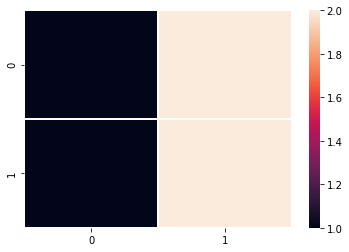

In [0]:
# !pip3 install git+https://github.com/PetrochukM/PyTorch-NLP.git
# from torchnlp.word_to_vector import GloVe
# vectors = GloVe(name  = 'twitter.27B',dim=50)

import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.random.rand(10, 12)
plotdata = [[1, 2,],[1, 2]]
ax = sns.heatmap(plotdata, linewidth=0.5)
plt.show()

In [0]:
# pickle.dump(a, open(f'/content/drive/My Drive/sentiment/pretrained.pkl', 'wb'))
# words = pickle.load(open(f'/content/drive/My Drive/sentiment/pretrained.pkl', 'rb'))
# print(words)

In [0]:
# # # # ################Generate Dataset1 train_count
# #train_xor.csv, test_xor.csv
# import numpy as np
# import csv
# torch.manual_seed(2109)
# np.random.seed(2109)
# dataset = []
# sentence_size = 200
# dataset_size = 8000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     if(((6 <= a) & (a <8)).sum()>((8 <= a) & (a < 10)).sum()):
#       label = 1
#       dataset.append([a.tolist(),label])
#       i+=1
#     elif(((6 <= a) & (a <8)).sum()<((8 <= a) & (a < 10)).sum()):
#       label = 0
#       dataset.append([a.tolist(),label])
#       i+=1
# with open('/content/drive/My Drive/sentiment/Data/train_count200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 2000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     if(((6 <= a) & (a <8)).sum()>((8 <= a) & (a < 10)).sum()):
#       label = 1
#       dataset.append([a.tolist(),label])
#       i+=1
#     elif(((6 <= a) & (a <8)).sum()<((8 <= a) & (a < 10)).sum()):
#       label = 0
#       dataset.append([a.tolist(),label])
#       i+=1
# with open('/content/drive/My Drive/sentiment/Data/val_count200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 3000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     if(((6 <= a) & (a <8)).sum()>((8 <= a) & (a < 10)).sum()):
#       label = 1
#       dataset.append([a.tolist(),label])
#       i+=1
#     elif(((6 <= a) & (a <8)).sum()<((8 <= a) & (a < 10)).sum()):
#       label = 0
#       dataset.append([a.tolist(),label])
#       i+=1
# with open('/content/drive/My Drive/sentiment/Data/test_count200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()



# # #Generate dataset xor
# # # #train_first.csv, test_first.csv
# torch.manual_seed(2109)
# np.random.seed(2109)
# dataset = []
# sentence_size = 200
# dataset_size = 8000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(10)).astype(int)
#     label = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         label = 1
#         break
#       elif (8 <= j) & (j < 10):
#         label = 0
#         break
#     if label==-1:
#       continue
#     dataset.append([a.tolist(),label])
#     i+=1
# with open('/content/drive/My Drive/sentiment/Data/train_first200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 2000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(10)).astype(int)
#     label = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         label = 1
#         break
#       elif (8 <= j) & (j < 10):
#         label = 0
#         break
#     if label==-1:
#       continue
#     dataset.append([a.tolist(),label])
#     i+=1
# with open('/content/drive/My Drive/sentiment/Data/val_first200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 3000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(10)).astype(int)
#     label = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         label = 1
#         break
#       elif (8 <= j) & (j < 10):
#         label = 0
#         break
#     if label==-1:
#       continue
#     dataset.append([a.tolist(),label])
#     i+=1
# with open('/content/drive/My Drive/sentiment/Data/test_first200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# # Generate dataset xor
# #train_xor.csv, test_xor.csv
# torch.manual_seed(2109)
# np.random.seed(2109)
# dataset = []
# sentence_size = 200
# dataset_size = 8000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         if first ==-1:
#           first = 1
#         else:
#           second = 1
#           break
#       elif (8 <= j) & (j < 10):
#         if first ==-1:
#           first = 0
#         else:
#           second = 0
#           break
#     if first!=-1 and second!=-1:
#         if first ^ second == 1:
#           label = 1
#         else:
#           label = 0
#         dataset.append([a.tolist(),label])
#         i+=1
# with open('/content/drive/My Drive/sentiment/Data/train_xor200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 2000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         if first ==-1:
#           first = 1
#         else:
#           second = 1
#           break
#       elif (8 <= j) & (j < 10):
#         if first ==-1:
#           first = 0
#         else:
#           second = 0
#           break
#     if first!=-1 and second!=-1:
#         if first ^ second == 1:
#           label = 1
#         else:
#           label = 0
#         dataset.append([a.tolist(),label])
#         i+=1
# with open('/content/drive/My Drive/sentiment/Data/val_xor200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()

# dataset = []
# dataset_size = 3000
# cnt = 0
# i=0
# while i<dataset_size:
#     a = np.floor(10*np.random.rand(sentence_size)).astype(int)
#     label = 1
#     first = -1
#     second = -1
#     for j in a:
#       if (6 <= j) & (j < 8):
#         if first ==-1:
#           first = 1
#         else:
#           second = 1
#           break
#       elif (8 <= j) & (j < 10):
#         if first ==-1:
#           first = 0
#         else:
#           second = 0
#           break
#     if first!=-1 and second!=-1:
#         if first ^ second == 1:
#           label = 1
#         else:
#           label = 0
#         dataset.append([a.tolist(),label])
#         i+=1
# with open('/content/drive/My Drive/sentiment/Data/test_xor200.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(dataset)
# csvFile.close()
# # print(len(dataset))

In [0]:
print(len(train_X_list))

NameError: ignored

In [0]:
#read data
import pandas as pd

print(train_data.shape)

(15000, 2)


In [0]:
iteration=0
for model_type in ['RNN']:
  for labelling_function in ['first', 'xor']:
    for hidden_dim in [3, 4, 5, 6, 7, 8]:
      for input_dim in [4, 5, 6, 7, 8]:
        drive.mount('/content/drive')
        #model_type = 'GRU'
        #labelling_function = 'xor'
        sequence_length = 10
        vocab_size = 10
        embedding_seed = 27
        model_seed = 2109
        #parameters
        # input_dim = 10
        output_dim = 2
        n_epochs = 150
        batch_size = 100
        lr = 0.001
        init_lr = lr
        # hidden_dim = 10
        patience_param = 4
        torch.manual_seed(embedding_seed)
        train_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/train_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
        val_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/val_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
        test_data = pd.read_csv('/content/drive/My Drive/sentiment/Data/test_{0}{1}.csv'.format(labelling_function, sequence_length), header = None)
        train_X_list = train_data[0].tolist()
        train_y = train_data[1].tolist()
        val_X_list = val_data[0].tolist()
        val_y = val_data[1].tolist()
        test_X_list = test_data[0].tolist()
        test_y = test_data[1].tolist()
        def stringToList(string):
            string = string[1:len(string)-1]
            if len(string) != 0: 
                tempList = string.split(", ")
                newList = list(map(lambda x: int(x), tempList))
            else:
                newList = []
            return(newList)
        train_X_list = [stringToList(x) for x in train_X_list]
        train_X = torch.tensor(train_X_list, dtype=torch.long)
        val_X_list = [stringToList(x) for x in val_X_list]
        val_X = torch.tensor(val_X_list, dtype=torch.long)
        test_X_list = [stringToList(x) for x in test_X_list]
        test_X = torch.tensor(test_X_list, dtype=torch.long)
        #Get embeddings
        print(len(train_X_list[0]))
        embeddings = nn.Embedding(vocab_size, input_dim)
        train_input = embeddings(train_X)
        train_output = torch.tensor(train_y, dtype=torch.long)
        val_input = embeddings(val_X)
        val_output = torch.tensor(val_y, dtype=torch.long)
        test_input = embeddings(test_X)


        torch.manual_seed(model_seed)
        #Code used for TRAINING
        def evaluate(tempmodel, dataX, dataY, criterion):
            epoch_loss = 0
            epoch_acc = 0
            correct_pred = 0
            tempmodel.eval()
            with torch.no_grad():
                for i in range(0, dataX.shape[0], batch_size):
                    batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
                    batchX = batchX.to(device)
                    batchy = batchy.to(device)
                    output, hidden = tempmodel(batchX)          
                    loss = criterion(hidden, batchy)

                    epoch_loss += loss.item()*batch_size
                    _, predicted_labels = torch.max(hidden, 1)
                    correct_pred += (predicted_labels==batchy).sum().item()
                accuracy = correct_pred/ len(dataX)*100
                epoch_loss /= len(dataX)   
            return epoch_loss, accuracy

        if torch.cuda.is_available():
            device = torch.device("cuda")
            print("GPU is available")
        else:
            device = torch.device("cpu")
            print("GPU not available, CPU used")
          
        class Model(nn.Module):
            def __init__(self, input_size, output_size, hidden_dim, n_layers):
                super(Model, self).__init__()

                self.hidden_dim = hidden_dim
                self.n_layers = n_layers

                #Defining the layers
                if model_type== 'RNN':
                  self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
                elif model_type== 'GRU':
                  self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
                self.fc = nn.Linear(hidden_dim, output_size)
            
            def forward(self, x):
                
                hidden = self.init_hidden(batch_size)

                out, hidden = self.rnn(x, hidden)
                hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
                hidden = self.fc(hidden)
                return out, hidden
            
            def init_hidden(self, batch_size):
                hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
                hidden = hidden.to(device)
                return hidden
              
        # Instantiate the model with hyperparameters
        model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
        model.to(device)

        # Define Loss, Optimizer
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.to(device)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        k = 0
        training_loss = []
        validation_loss = []

        print('Epoch: {}/{}'.format(0, n_epochs), end=' ')
        curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
        training_loss.append([0, curTrainLoss, curTrainAccuracy])
        curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
        print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
        validation_loss.append([0, curValLoss, curValAccuracy])
        oldAcc = curValAccuracy
        for epoch in range(1, n_epochs + 1):
            model.train()
            for i in range(0, train_input.shape[0], batch_size):
                optimizer.zero_grad()
                batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                output, hidden = model(batch_X)
                loss = criterion(hidden, batch_y)
                loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
                optimizer.step() # Updates the weights accordingly
            
            print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
            curTrainLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
            print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
            training_loss.append([epoch, curTrainLoss, curTrainAccuracy])
            curValLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
            print(", Validation Accuracy: {:.4f}".format(curValAccuracy))
            validation_loss.append([epoch, curValLoss, curValAccuracy])
            final_epoch = epoch
            if(oldAcc>=curValAccuracy):
              if oldAcc>curValAccuracy:
                lr/=2
              k+=1
            else:
              k=0
            if(k>=patience_param or lr<1e-6):
              break
            oldAcc = curValAccuracy
        print('Training Done.')

        torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/{0}Model{1}_{2}{3}.pt'.format(model_type, hidden_dim,labelling_function,sequence_length))
        if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
          with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
            try:
              collection = json.loads(readjson.read())
            except ValueError:
              collection = []
        else:
          collection=[]
        with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
          collection_entry = {'sequence_number':len(collection)+1,'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':labelling_function, 'final_epoch':final_epoch,'train_loss':curTrainLoss, 'validation_loss':curValLoss,'train_accuracy':curTrainAccuracy, 'validation_accuracy':curValAccuracy, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]), 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,'initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs,'plot_train_loss':training_loss, 'plot_validation_loss':validation_loss}
          collection.append(collection_entry)
          json.dump(collection, f)
          print(iteration, )
          iteration+=1

Mounted at /content/drive
10
GPU is available
Epoch: 0/150 Training Accuracy: 50.2125  ,Validation Accuracy: 49.5500


KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import math
result = []
for i in range(30):
  print(pow(3, i+1), end=' ')
with open('/content/drive/My Drive/sentiment/Result/collection.json', mode = 'r') as f:
  result = json.loads(f.read())
print('-------------------XOR-------------------------------')
selected_records = [ [d['architecture'],d['model_seed'], d['hidden_dimension'], d['input_dimension'], d['validation_accuracy']] for d in result if d['input_dimension']==2 and d['hidden_dimension']==2 and d['architecture']=='GRU' and d['labelling_function']=='xor']
selected_records.sort()
for i in selected_records:
  print(i)
# print('-------------------First---------------------------')
# selected_records = [ [d['architecture'], d['hidden_dimension'], d['input_dimension'],  d['validation_accuracy']] for d in result if 1]
# selected_records.sort()
# for i in selected_records:
#   print(i)
# print(len(selected_records))
# x = []
# y = []
# for i in selected_records:
#   if(i[0]=='GRU'):
#     x.append(float(i[2]))
#     y.append(float(i[3]))
#   print(i)
# plt.plot(x, y)

3 9 27 81 243 729 2187 6561 19683 59049 177147 531441 1594323 4782969 14348907 43046721 129140163 387420489 1162261467 3486784401 10460353203 31381059609 94143178827 282429536481 847288609443 2541865828329 7625597484987 22876792454961 68630377364883 205891132094649 -------------------XOR-------------------------------
['GRU', 3, 2, 2, 48.0]
['GRU', 3, 2, 2, 48.0]
['GRU', 9, 2, 2, 49.8]
['GRU', 27, 2, 2, 51.449999999999996]
['GRU', 27, 2, 2, 51.449999999999996]
['GRU', 27, 2, 2, 51.449999999999996]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 27, 2, 2, 51.800000000000004]
['GRU', 81, 2, 2, 50.5]
['GRU', 108, 2, 2, 50.349999999999994]
['GRU', 108, 2, 2, 50.349999999999994]
['GRU', 108, 2, 2, 50.349999999999994]
['GRU', 108, 2, 2, 50.74999999999999]
['GRU', 108, 2, 2, 50.74999999999999]
['GRU', 108, 2, 2, 50.74999999999999]
['GRU', 243, 2

In [0]:
torch.manual_seed(2109)
#Code used for TRAINING
def evaluate(tempmodel, dataX, dataY, criterion):
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
  
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=1)
model.to(device)

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
        print('Epoch: {}/{}'.format(epoch, n_epochs), end=' ')
        curTrainAccuracyLoss, curTrainAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Accuracy: {:.4f}".format(curTrainAccuracy), end=' ')
        training_loss.append([epoch, curTrainAccuracyLoss, curTrainAccuracy])
        curValAccuracyLoss, curValAccuracy = evaluate(model, val_input, val_output, criterion)
        print(" ,Validation Accuracy: {:.4f}".format(curValAccuracy))
        validation_loss.append([epoch, curValAccuracyLoss, curValAccuracy])
        final_epoch = epoch
        if(oldAcc>=printAccuracy):
          if oldAcc>curValAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          break
        oldAcc = curValAccuracy
print('Training Done.')

torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/RNNModel{0}_{1}{2}.pt'.format(hidden_dim,labelling_function,sequence_length))
if os.path.isfile('/content/drive/My Drive/sentiment/Result/collection.json'):
  with open('/content/drive/My Drive/sentiment/Result/collection.json', mode='r') as readjson:
    try:
      collection = json.loads(readjson.read()):
    except ValueError:
      collection = []
else:
  collection=[]
with open('/content/drive/My Drive/sentiment/Result/collection.json', 'w') as f:
  json.dump(collection.append({'sequence_number':len(collection),'architecture':model_type, 'input_dimension':input_dim,'output_dimension':output_dim,'hidden_dimension':hidden_dim,'labelling_function':  labelling_function,'final_epoch':final_epoch,'train_loss':training_accuracy, 'validation_accuracy': validation_loss,'train_loss':training_loss, 'validation_loss': validation_loss, 'trainset_size':len(train_X_list), 'validationset_size':len(val_X_list), 'testset_size':len(test_X_list),'sequence_length':len(train_X_list[0]) 'vocab_size':10, 'embedding_seed':embedding_seed,'model_seed': model_seed,initial_learning_rate':init_lr, 'final_learning_rate':lr , 'batch_size':batch_size,'patience_parameter':patience_param,'total_epochs':n_epochs}), f)

GPU is available
Training Loss and Accuracy: 0.6968, 49.9133
Validation Loss and Accuracy: 0.6965, 51.5000
Epoch: 1/150............. Training Loss and Accuracy: 0.6941, 50.2400
Validation Loss and Accuracy: 0.6944, 48.4000
Epoch: 2/150............. Training Loss and Accuracy: 0.6936, 50.2467
Validation Loss and Accuracy: 0.6938, 50.0500
Epoch: 3/150............. Training Loss and Accuracy: 0.6934, 50.4067
Validation Loss and Accuracy: 0.6935, 50.3500
Epoch: 4/150............. Training Loss and Accuracy: 0.6932, 50.2667
Validation Loss and Accuracy: 0.6934, 49.8500
Epoch: 5/150............. Training Loss and Accuracy: 0.6932, 50.3267
Validation Loss and Accuracy: 0.6933, 50.3000
Epoch: 6/150............. Training Loss and Accuracy: 0.6931, 50.6067
Validation Loss and Accuracy: 0.6932, 50.9500
Epoch: 7/150............. Training Loss and Accuracy: 0.6931, 50.6933
Validation Loss and Accuracy: 0.6932, 50.9000
Epoch: 8/150............. Training Loss and Accuracy: 0.6931, 50.7600
Validation 

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))


In [0]:
#################plain RNN
hidden_dimension = 8
lr = 0.001
torch.manual_seed(2109)
#Code used for TRAINING
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # GRU Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)



# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if 1:
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        training_loss.append([epoch, printLoss, printAccuracy])
        printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
        print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        validation_loss.append([epoch, printLoss, printAccuracy])
        if(oldAcc>=printAccuracy):
          if oldAcc>printAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          print(lr)
          break
        oldAcc = printAccuracy
print('Training Done.')
torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/RNNModel8_first50.pt')
with open('/content/drive/My Drive/sentiment/Result/RNNModel8_first50.json', 'w') as f:
  json.dump({'training':training_loss, 'validation': validation_loss}, f)

GPU is available
Training Loss and Accuracy: 0.7639, 49.6400
Validation Loss and Accuracy: 0.7700, 48.7000
Epoch: 1/150............. Training Loss and Accuracy: 0.6938, 49.4533
Validation Loss and Accuracy: 0.6940, 49.0500
GPU is available
Training Loss and Accuracy: 0.7639, 49.6400
Validation Loss and Accuracy: 0.7700, 48.7000
Epoch: 1/150............. Training Loss and Accuracy: 0.6938, 49.4533
Validation Loss and Accuracy: 0.6940, 49.0500
Epoch: 2/150............. Training Loss and Accuracy: 0.6932, 50.0000
Validation Loss and Accuracy: 0.6934, 48.0500
Epoch: 2/150............. Training Loss and Accuracy: 0.6932, 50.0000
Validation Loss and Accuracy: 0.6934, 48.0500
Epoch: 3/150............. Training Loss and Accuracy: 0.6931, 50.3133
Validation Loss and Accuracy: 0.6933, 49.9000
Epoch: 3/150............. Training Loss and Accuracy: 0.6931, 50.3133
Validation Loss and Accuracy: 0.6933, 49.9000
Epoch: 4/150............. Training Loss and Accuracy: 0.6930, 50.7533
Validation Loss and 

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))


In [0]:
#################plain RNN
lr = 0.001
hidden_dimension = 10
torch.manual_seed(2109)
#Code used for TRAINING
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # GRU Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)



# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if 1:
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        training_loss.append([epoch, printLoss, printAccuracy])
        printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
        print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        validation_loss.append([epoch, printLoss, printAccuracy])
        if(oldAcc>=printAccuracy):
          if oldAcc>printAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          print(lr)
          break
        oldAcc = printAccuracy
print('Training Done.')
torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/RNNModel10_first200.pt')
with open('/content/drive/My Drive/sentiment/Result/RNNModel10_first200.json', 'w') as f:
  json.dump({'training':training_loss, 'validation': validation_loss}, f)

GPU is available
Training Loss and Accuracy: 0.7139, 49.6400
Validation Loss and Accuracy: 0.7190, 48.7000
Epoch: 1/150............. Training Loss and Accuracy: 0.6931, 50.9400
Validation Loss and Accuracy: 0.6941, 49.4500
Epoch: 2/150............. Training Loss and Accuracy: 0.6929, 50.7267
Validation Loss and Accuracy: 0.6936, 51.0500
Epoch: 3/150............. Training Loss and Accuracy: 0.6927, 51.0867
Validation Loss and Accuracy: 0.6933, 51.3500
Epoch: 4/150............. Training Loss and Accuracy: 0.6921, 51.8933
Validation Loss and Accuracy: 0.6929, 51.6000
Epoch: 5/150............. Training Loss and Accuracy: 0.5794, 70.2400
Validation Loss and Accuracy: 0.5747, 71.6000
Epoch: 6/150............. Training Loss and Accuracy: 0.3985, 82.1333
Validation Loss and Accuracy: 0.4009, 81.7000
Epoch: 7/150............. Training Loss and Accuracy: 0.3490, 84.8600
Validation Loss and Accuracy: 0.3636, 84.5500
Epoch: 8/150............. Training Loss and Accuracy: 0.3201, 86.4600
Validation 

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))


In [0]:
#################GRU
hidden_dimension = 4
lr = 0.001
torch.manual_seed(2109)
#Code used for TRAINING
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # GRU Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)



# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if 1:
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        training_loss.append([epoch, printLoss, printAccuracy])
        printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
        print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        if(oldAcc>=printAccuracy):
          if oldAcc>printAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          print(lr)
          break
        oldAcc = printAccuracy
print('Training Done.')
torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/GRUModel4_first50.pt')
with open('/content/drive/My Drive/sentiment/Result/GRUModel4_first50.json', 'w') as f:
  json.dump({'training':training_loss, 'validation': validation_loss}, f)

GPU is available
Training Loss and Accuracy: 0.7043, 50.3600
Validation Loss and Accuracy: 0.7022, 51.3000
GPU is available
Training Loss and Accuracy: 0.7043, 50.3600
Validation Loss and Accuracy: 0.7022, 51.3000
Epoch: 1/150............. Training Loss and Accuracy: 0.6909, 53.8933
Validation Loss and Accuracy: 0.6918, 53.6000
Epoch: 1/150............. Training Loss and Accuracy: 0.6909, 53.8933
Validation Loss and Accuracy: 0.6918, 53.6000
Epoch: 2/150............. Training Loss and Accuracy: 0.6834, 58.2133
Validation Loss and Accuracy: 0.6846, 57.3000
Epoch: 2/150............. Training Loss and Accuracy: 0.6834, 58.2133
Validation Loss and Accuracy: 0.6846, 57.3000
Epoch: 3/150............. Training Loss and Accuracy: 0.6560, 63.0533
Validation Loss and Accuracy: 0.6577, 63.0000
Epoch: 3/150............. Training Loss and Accuracy: 0.6560, 63.0533
Validation Loss and Accuracy: 0.6577, 63.0000
Epoch: 4/150............. Training Loss and Accuracy: 0.5248, 74.5600
Validation Loss and 

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))

In [0]:
#################plain GRU
lr = 0.001
hidden_dimension = 8
torch.manual_seed(2109)
#Code used for TRAINING
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # GRU Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)



# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if 1:
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        training_loss.append([epoch, printLoss, printAccuracy])
        printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
        print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        validation_loss.append([epoch, printLoss, printAccuracy])
        if(oldAcc>=printAccuracy):
          if oldAcc>printAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          print(lr)
          break
        oldAcc = printAccuracy
print('Training Done.')
torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/GRUModel8_first50.pt')
with open('/content/drive/My Drive/sentiment/Result/GRUModel8_first50.json', 'w') as f:
  json.dump({'training':training_loss, 'validation': validation_loss}, f)

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))

In [0]:
#################GRU Units
lr = 0.001
hidden_dimension = 10
torch.manual_seed(2109)
#Code used for TRAINING
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # GRU Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)



# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
k = 0
training_loss = []
validation_loss = []

print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
training_loss.append([0, printLoss, printAccuracy])
printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
validation_loss.append([0, printLoss, printAccuracy])
oldAcc = printAccuracy

for epoch in range(1, n_epochs + 1):
    model.train()
    for i in range(0, train_input.shape[0], batch_size):
        optimizer.zero_grad()
        batch_X, batch_y = train_input[i:i+batch_size], train_output[i:i+batch_size]
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output, hidden = model(batch_X)
        loss = criterion(hidden, batch_y)
        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if 1:
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        printLoss, printAccuracy = evaluate(model, train_input, train_output, criterion)
        print("Training Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        training_loss.append([epoch, printLoss, printAccuracy])
        printLoss, printAccuracy = evaluate(model, val_input, val_output, criterion)
        print("Validation Loss and Accuracy: {:.4f}, {:.4f}".format(printLoss, printAccuracy))
        validation_loss.append([epoch, printLoss, printAccuracy])
        if(oldAcc>=printAccuracy):
          if oldAcc>printAccuracy:
            lr/=2
          k+=1
        else:
          k=0
        if(k>=patience_param or lr<1e-6):
          print(lr)
          break
        oldAcc = printAccuracy
print('Training Done.')
torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/GRUModel10_first200.pt')
with open('/content/drive/My Drive/sentiment/Result/GRUModel10_first200.json', 'w') as f:
  json.dump({'training':training_loss, 'validation': validation_loss}, f)

GPU is available
Training Loss and Accuracy: 0.6955, 50.3667
Validation Loss and Accuracy: 0.6945, 51.3000
Epoch: 1/150............. Training Loss and Accuracy: 0.6926, 51.9133
Validation Loss and Accuracy: 0.6927, 51.3500
Epoch: 2/150............. Training Loss and Accuracy: 0.6869, 58.0200
Validation Loss and Accuracy: 0.6877, 56.7500
Epoch: 3/150............. Training Loss and Accuracy: 0.5538, 72.8067
Validation Loss and Accuracy: 0.5546, 73.1000
Epoch: 4/150............. Training Loss and Accuracy: 0.3703, 82.6733
Validation Loss and Accuracy: 0.3808, 81.7000
Epoch: 5/150............. Training Loss and Accuracy: 0.2879, 87.4600
Validation Loss and Accuracy: 0.2974, 86.7000
Epoch: 6/150............. Training Loss and Accuracy: 0.2308, 90.5067
Validation Loss and Accuracy: 0.2434, 89.5000
Epoch: 7/150............. Training Loss and Accuracy: 0.2020, 91.8667
Validation Loss and Accuracy: 0.2130, 90.7000
Epoch: 8/150............. Training Loss and Accuracy: 0.1810, 92.8800
Validation 

In [0]:
torch.manual_seed(2109)
#Get embeddings
embeddings = nn.Embedding(10, input_dim)
train_input = embeddings(train_X)
train_output = torch.tensor(train_y, dtype=torch.long)

val_input = embeddings(val_X)
val_output = torch.tensor(val_y, dtype=torch.long)
test_input = embeddings(test_X)
result = []
# pickle.dump({'train':train_input, 'trainy':train_y, 'validation':val_input, 'valy':val_y, 'test':test_input},open(f'/content/drive/My Drive/sentiment/Result/InputEmbeddings.pkl', 'wb'))

In [0]:
#########Inference
input_dim = 10
output_dim = 2
n_epochs = 50
batch_size = 100
lr=0.001

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)

        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden

# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=10, n_layers=1)
model.load_state_dict(torch.load('/content/drive/My Drive/sentiment/Model/myModelsmall10.pt'))
# model.eval()
# model = model.to(device)
# batch_X, batch_y = train_input[0:1], train_output[0:1]
# batch_X = batch_X.to(device)
# batch_y = batch_y.to(device)
# output, hidden = model(batch_X)

In [0]:
import json
result = []
with open('/content/drive/My Drive/sentiment/Result/SecondResultSmall.json', 'w') as f:
          json.dump(result, f)

In [0]:
#save the model
# torch.save(model.state_dict(), '/content/drive/My Drive/sentiment/Model/')
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)
#         print(out.shape)
#         print(hidden.shape)

        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
#         print(out.shape, hidden.shape)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
#Load the model

model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.load_state_dict(torch.load('/content/drive/My Drive/sentiment/Model/myModelsmall10.pt'))
# model.eval()

In [0]:
#########Read JSON File
import json
with open('/content/drive/My Drive/sentiment/Result/FirstResult.json', 'r') as f:
  result = json.loads(f.read())
print(len(result))

In [0]:
########Load Model
torch.manual_seed(2109)
#Code
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate(tempmodel, dataX, dataY, criterion):
  
    epoch_loss = 0
    epoch_acc = 0
    correct_pred = 0
    tempmodel.eval()
    with torch.no_grad():
        for i in range(0, dataX.shape[0], batch_size):
            batchX, batchy = dataX[i:i+batch_size], dataY[i:i+batch_size]
            batchX = batchX.to(device)
            batchy = batchy.to(device)
            output, hidden = tempmodel(batchX)          
            loss = criterion(hidden, batchy)

            epoch_loss += loss.item()*batch_size
            _, predicted_labels = torch.max(hidden, 1)
            correct_pred += (predicted_labels==batchy).sum().item()
        accuracy = correct_pred/ len(dataX)*100
        epoch_loss /= len(dataX)   
    return epoch_loss, accuracy

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
    
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)
#         print(out.shape)
#         print(hidden.shape)

        hidden = hidden.transpose(0,1).contiguous().view(batch_size, -1)
        hidden = self.fc(hidden)
#         print(out.shape, hidden.shape)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        hidden = hidden.to(device)
        return hidden
      
# Instantiate the model with hyperparameters
model = Model(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dimension, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.load_state_dict(torch.load('/content/drive/My Drive/sentiment/Model/myModelsmall8.pt'))
model.to(device)


In [0]:
###Get parameters of the loaded model
ordir = model.state_dict()
print(ordir)
# InputParam = ordir['rnn.weight_ih_l0'].cpu()
# InputBias = ordir['rnn.bias_ih_l0'].cpu()
# HiddenParam = ordir['rnn.weight_hh_l0'].cpu()
# HiddenBias = ordir['rnn.bias_hh_l0'].cpu()
InputParam = model.state_dict()['rnn.weight_ih_l0'].cpu()
InputBias = model.state_dict()['rnn.bias_ih_l0'].cpu()
HiddenParam = model.state_dict()['rnn.weight_hh_l0'].cpu()
HiddenBias = model.state_dict()['rnn.bias_hh_l0'].cpu()

In [0]:
##############################Product of parameter and input word vector
# train_input[0].to(device)
# # InputParam[0].to(device)
# InputParam[0]*train_input[0]
# train_input.to(device)
for i in range(100):
    inputword = embeddings(torch.tensor(i, dtype=torch.long))
    print(torch.norm(torch.mm(InputParam,inputword.view(10,1)))#default fr
#     print(torch.sum(torch.mm(InputParam,inputword.view(10,1))+InputBias.view(8,1)))